In [2]:
library(rstan)
library(brms)
library(here)
library(ggplot2)
library(bayesplot)


# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


要求されたパッケージ Rcpp をロード中です

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


次のパッケージを付け加えます: ‘brms’


以下のオブジェクトは ‘package:rstan’ からマスクされています:

    loo


以下のオブジェクトは ‘package:stats’ からマスクされています:

    ar


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot:

In [3]:
fish_num_climate_2 <- read.csv(here("data", "4-1-1-fish-num-2.csv"))

fish_num_climate_2$id <- as.factor(fish_num_climate_2$id)
head(fish_num_climate_2, n = 3)


,fish_num,weather,temperature,id
,<int>,<chr>,<dbl>,<fct>
1,0,cloudy,5.0,1
2,1,cloudy,24.2,2
3,6,cloudy,11.5,3


Compiling Stan program...

Start sampling

Warning message:
“Argument 'probs' is deprecated. Please use 'prob' instead.”


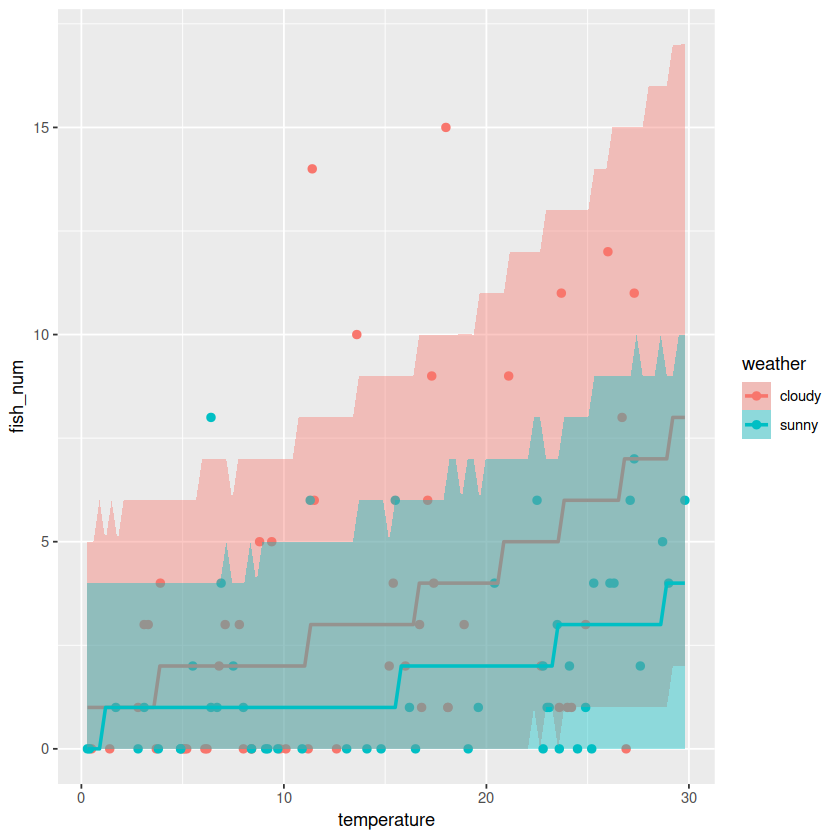

In [9]:
glm_pois_brms <- brm(
  formula = fish_num ~ weather + temperature,
  family = poisson(),
  data = fish_num_climate_2,
  seed = 1,
  prior = c(set_prior("", class = "Intercept"))
)

set.seed(1)
eff_glm_pre <- conditional_effects(
  glm_pois_brms,
  method = "predict",
  effects = "temperature:weather",
  probs = c(0.005, 0.995)
)

plot(eff_glm_pre, points = T)


In [4]:
formula_pois <- formula(fish_num ~ weather + temperature)
design_mat <- model.matrix(formula_pois, fish_num_climate_2)
sunny_dummy <- as.numeric(design_mat[, "weathersunny"])
data_list_1 <- list(
  N = nrow(fish_num_climate_2),
  fish_num = fish_num_climate_2$fish_num,
  temp = fish_num_climate_2$temperature,
  sunny = sunny_dummy
)


In [5]:
glmm_pois_stan <- stan(
  file = "4-1-1-glmm-pois.stan",
  data = data_list_1,
  seed = 1
)


Warning message in readLines(file, warn = TRUE):
“'/media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング/4部/4-1-1-glmm-pois.stan' で不完全な最終行が見つかりました”


recompiling to avoid crashing R session



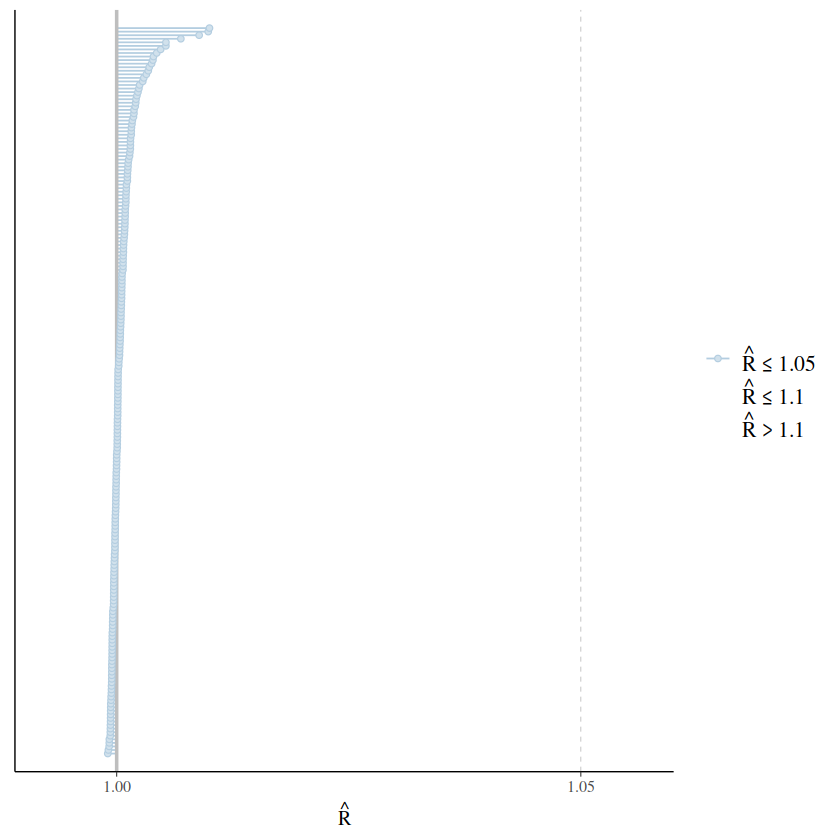

In [6]:
mcmc_rhat(rhat(glmm_pois_stan))


In [7]:
glm_pois_brms <- brm(
  formula = fish_num ~ weather + temperature + (1 | id),
  family = poisson(),
  data = fish_num_climate_2,
  seed = 1,
  prior = c(
    set_prior("", class = "Intercept"),
    set_prior("", class = "sd")
  )
)


Compiling Stan program...

Start sampling



In [9]:
glm_pois_brms


 Family: poisson 
  Links: mu = log 
Formula: fish_num ~ weather + temperature + (1 | id) 
   Data: fish_num_climate_2 (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~id (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.09      0.15     0.82     1.43 1.00      951     1848

Regression Coefficients:
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.46      0.34    -1.16     0.15 1.01     1446     1889
weathersunny    -0.72      0.29    -1.30    -0.17 1.00     1081     1862
temperature      0.08      0.02     0.04     0.11 1.00     1211     1885

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).